<a href="https://colab.research.google.com/github/byeongdon/hanghae99/blob/main/1%EC%A3%BC%EC%B0%A8%20%EA%B3%BC%EC%A0%9CA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.ToTensor()
batch_size = 256

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True, #시험범위를 준다는 느낌
    download=True,
    transform=transform
)

testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,# 시험을 치르고 있는 느낌
    download=True,
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

60000
torch.Size([1, 28, 28]) 5


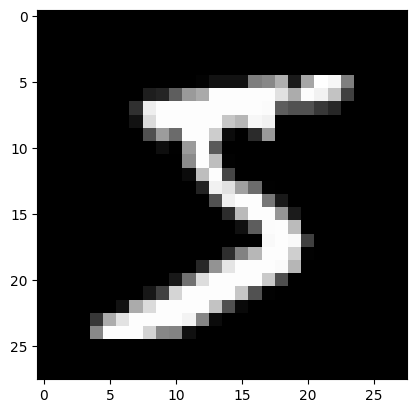

In [ ]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


input_dim = 20
n_dim = 5라고 가정

n_dim의 갯수는 데이터의 갯수가 많으면 숫자를 늘려야 되고,
데이터 갯수가 적으면 숫자를 줄여야 됨. 단 테스트를 해봐야 알 수 있고, 어느 순간에 꺾이는 순간이 있음.

layer1에서는 20, 5가 들어가고
layer2에서는 5, 5
layer3에서는 5,10

즉, input_dim이 가로, n_dim이 세로라고 가정했을 때

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim) # port로 비교하자면 input_dim : 외부 port
    print(self.layer1)
    self.layer2 = nn.Linear(n_dim, n_dim)
    print(self.layer2)
    self.layer3 = nn.Linear(n_dim, 10) # 0~9 --> 가장 마지막에 나오는 숫자의 총 갯수
    print(self.layer3)
    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(28 * 28 * 1, 1024)

Linear(in_features=784, out_features=1024, bias=True)
Linear(in_features=1024, out_features=1024, bias=True)
Linear(in_features=1024, out_features=10, bias=True)


In [ ]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [ ]:
n_epochs = 100
lose_fn = nn.CrossEntropyLoss()

train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = lose_fn(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  for data in testloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)

    #loss = lose_fn(preds, labels) --> test loader에서는 loss가 필요없음 loss를 주면 시험에서 오픈북시험과 같은 느낌
    #loss.backward()
    #optimizer.step()

    #total_loss += loss.item()
    #accuracy는 정확도만 판단
  train_accs.append(accuracy(model, trainloader))
  test_accs.append(accuracy(model, testloader))

  #print(f"train_accs {train_accs}")
  #print(f"test_accs {test_accs}")
  print(f"Epoch {epoch:3d} | Loss: {total_loss}")



Epoch   0 | Loss: 540.7028851509094
Epoch   1 | Loss: 538.9716310501099
Epoch   2 | Loss: 536.9006097316742
Epoch   3 | Loss: 534.3559894561768
Epoch   4 | Loss: 531.5113217830658
Epoch   5 | Loss: 528.4007785320282
Epoch   6 | Loss: 524.798907995224
Epoch   7 | Loss: 520.830774307251
Epoch   8 | Loss: 516.4237825870514
Epoch   9 | Loss: 511.5553095340729
Epoch  10 | Loss: 506.0763485431671
Epoch  11 | Loss: 499.8272330760956
Epoch  12 | Loss: 492.52624464035034
Epoch  13 | Loss: 484.4160737991333
Epoch  14 | Loss: 475.3688782453537
Epoch  15 | Loss: 465.2658029794693
Epoch  16 | Loss: 454.235603928566
Epoch  17 | Loss: 442.21871304512024
Epoch  18 | Loss: 429.2546776533127
Epoch  19 | Loss: 415.33577036857605
Epoch  20 | Loss: 400.6672399044037
Epoch  21 | Loss: 385.5184509754181
Epoch  22 | Loss: 370.17298090457916
Epoch  23 | Loss: 354.95949280261993
Epoch  24 | Loss: 339.94816184043884
Epoch  25 | Loss: 325.75297725200653
Epoch  26 | Loss: 312.49476289749146
Epoch  27 | Loss: 300.2

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[2.4686, 0.0000, 0.3620, 4.6814, 0.0000, 4.7054, 0.0000, 0.0000, 0.8011,
         0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)
5


In [ ]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

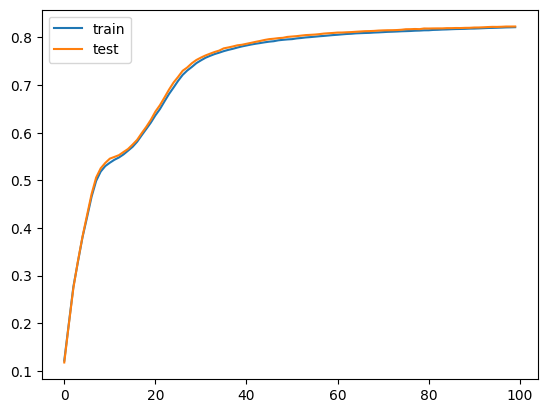

In [ ]:
plot_acc(train_accs,test_accs)

메모

